In [50]:
import pandas as pd
import numpy as np
import importlib
import WhatsappParse

import matplotlib.pyplot as plt
import matplotlib as mpl

from gensim import corpora, models, similarities
from pprint import pprint

In [51]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'

In [52]:
input_file = "WA_digging.txt"

with open(input_file, "r", encoding="utf-8") as f:
    content = f.read()

chat = WhatsappParse.parse_convo(content)
sys_msgs = WhatsappParse.parse_sysmsg(content)

In [53]:
chat_df = pd.DataFrame(chat+sys_msgs, columns=['timestamp','user','message'])
chat_df['user'] = chat_df['user'].apply(lambda s: s[:2]) # Censoring names for privacy

In [54]:
chat_df.head()

,timestamp,user,message
0,"10/02/2015, 12:23",os,כשאמא ואבא בני דודים 😂
1,"10/02/2015, 12:26",אל,יותר גרוע...אחים חחח
2,"10/02/2015, 12:26",אמ,חחחחחחח
3,"10/02/2015, 12:34",סה,חחח
4,"10/02/2015, 12:48",אמ,אני מכיר אותו הוא דיי שרוט


In [60]:
chat_df['timestamp'] = pd.to_datetime(chat_df['timestamp']) # Convert datetime type

In [61]:
messages = chat_df['message']

In [62]:
all_text = ' '.join(chat_df['message']) # Get all text as a block to count overall occurences of words

In [63]:
# Clean text
all_text = all_text.replace('\n',' ').replace('\r',' ').replace('<Media omitted>','<Media>')

In [64]:
all_text[:100]

'כשאמא ואבא בני דודים 😂 יותר גרוע...אחים חחח חחחחחחח חחח אני מכיר אותו הוא דיי שרוט חחחחחחח כמה שגיאו'

Seperate words by spaces

In [65]:
#tokenized = messages.apply(str.split,args=(' '))
tokenized = all_text.split(' ')
distinct_words = set(tokenized)

In [66]:
len(tokenized) # Overall word count

142869

In [67]:
len(distinct_words) # Distinct word count

28860

## find in text

In [68]:

index_of = all_text.find('חחחחחחחחחחחחחחחחחחחחחח')
all_text[index_of:index_of+50]

'חחחחחחחחחחחחחחחחחחחחחחחחח ברביקיו איזה שם מצחיק זה'

## frequencies

In [69]:
words_count = list(map(lambda x: tokenized.count(x), distinct_words)) # Count all words

In [70]:
counts_arr = np.asarray(words_count)
words_freq = counts_arr/np.sum(counts_arr) # Calc freq

In [71]:
# Bag of words
bow = pd.DataFrame(data={'word':list(distinct_words),'count': words_count,'freq': words_freq},columns=['word','count','freq'])

In [72]:
bow.where(bow['word'] == 'wtf').dropna()

,word,count,freq
19695,wtf,6.0,0.000042


# Cool findings

## leavers

In [2]:
## user (sy)stem is system messages
chat_df.where(chat_df['user'] == 'sy').dropna().where(chat_df['message'].apply(lambda m: 'left' in m)).dropna()

## top X words

,word,count,freq
1,לא,3636.0,0.025450
2,אני,2940.0,0.020578
3,זה,2818.0,0.019724
4,<Media>,2088.0,0.014615
5,חחח,1873.0,0.013110
6,את,1807.0,0.012648
7,מה,1393.0,0.009750
8,לי,1338.0,0.009365
9,חחחח,1223.0,0.008560
10,יש,1195.0,0.008364


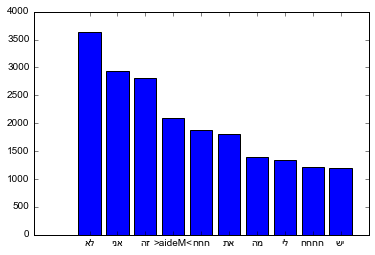

In [79]:
N = 10

top_words = bow.where(bow['word'].str.len() > 0).dropna().sort_values('count',ascending=False)

bar_labels = list(map(lambda w: w[::-1], top_words['word'].head(N)))

plt.bar(range(N),top_words['count'].head(N), tick_label=bar_labels, align='center')

M = 30

brief_top = top_words.head(M)

brief_top.index = range(1,M+1)

brief_top

## Top senders

### by message count

([<matplotlib.patches.Wedge at 0x1be39ae8160>,
  <matplotlib.text.Text at 0x1be3e397eb8>])

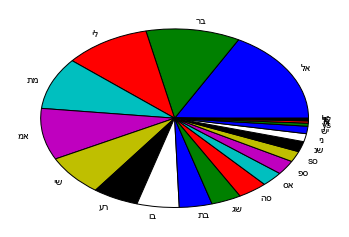

In [80]:
chat_df['len'] = chat_df['message'].apply(len)

top_senders = pd.DataFrame(chat_df.groupby('user',as_index=False).size().sort_values(ascending=False),columns=['msg_count']).reset_index()

fig = plt.figure()

user_labels = list(map(lambda u: u[::-1],top_senders['user']))

plt.pie(top_senders['msg_count'],labels=user_labels)
#plt.savefig('pie.png')

### by total chars

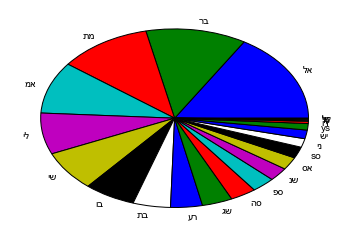

In [81]:
top_lens = pd.DataFrame(chat_df.groupby('user',as_index=False).sum()).sort_values('len',ascending=False)

fig = plt.figure()

user_labels = list(map(lambda u: u[::-1],top_lens['user']))

plt.pie(top_lens['len'],labels=user_labels)
plt.savefig("len_pie.png")

In [82]:
top_lens[['user','len']]

,user,len
2,אל,114906
6,בר,85414
11,מת,79011
3,אמ,66267
10,לי,52543
19,שי,51197
5,בו,43517
7,בת,31875
17,רע,27028
18,שג,25849


## Dates and times

,weekday,msg_count,i
6,6,5565,1
0,0,4794,2
1,1,4908,3
2,2,4309,4
3,3,3726,5
4,4,5451,6
5,5,3631,7


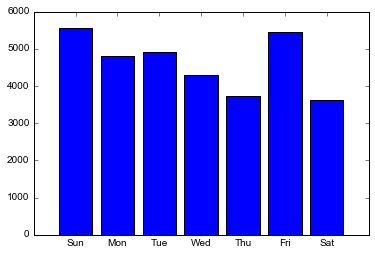

In [85]:
chat_df['year'] = [t.year for t in chat_df.timestamp]
chat_df['month'] = [t.month for t in chat_df.timestamp]
chat_df['weekday'] = [t.dayofweek for t in chat_df.timestamp]
chat_df['hourofday'] = [str(t.hour).zfill(2) for t in chat_df.timestamp]

top_days = pd.DataFrame(chat_df.groupby('weekday',as_index=False).size(),columns=['msg_count']).reset_index()
top_days['i'] = [2,3,4,5,6,7,1]
bar_labels = ['Sun', 'Mon','Tue','Wed','Thu','Fri','Sat']

top_days = top_days.sort_values('i')

plt.bar(range(7),top_days['msg_count'], tick_label=bar_labels, align='center')
top_days

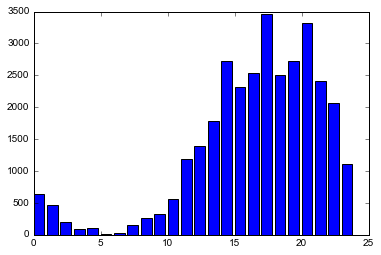

In [86]:
top_hours = pd.DataFrame(chat_df.groupby('hourofday',as_index=False).size(),columns=['msg_count']).reset_index()

barplot = plt.bar(range(int(chat_df['hourofday'].max())+1),top_hours['msg_count'])


## Media

([<matplotlib.patches.Wedge at 0x1be3b727358>,
  <matplotlib.text.Text at 0x1be3b77a7f0>])

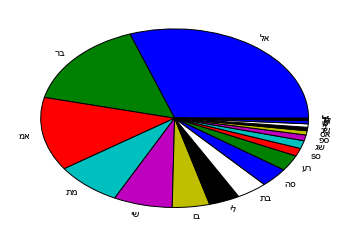

In [87]:
top_senders = pd.DataFrame(chat_df.where(chat_df['message'] == '<Media omitted>').groupby('user',as_index=False).size().sort_values(ascending=False),columns=['msg_count']).reset_index()
fig = plt.figure()
user_labels = list(map(lambda u: u[::-1],top_senders['user']))
plt.pie(top_senders['msg_count'],labels=user_labels)
#fig.savefig("media_pie.png")

In [89]:
top_senders.max()['msg_count']/top_senders.sum()['msg_count'] # Media percentage of top media sender

0.30411877394636017